<a href="https://colab.research.google.com/github/andre-gam/curry-stats/blob/main/currystats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm 
import statistics 
import scipy.stats as stats
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import metrics
from datetime import datetime
from sklearn import metrics
from sklearn.neural_network import MLPRegressor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [19]:
#Carregas os dataframes de acordo com csv

stand2015 = pd.read_csv("standings2015-2016.csv")
stand2016 = pd.read_csv("standings2016-2017.csv")
stand2017 = pd.read_csv("standings2017-2018.csv")
stand2018 = pd.read_csv("standings2018-2019.csv")
stand2020 = pd.read_csv("standings2020-2021.csv")
stand2021 = pd.read_csv("standings2021-2022.csv")
stand2022 = pd.read_csv("standings2022-2023.csv")

stats2015 = pd.read_csv("stats2015-2016.csv")
stats2016 = pd.read_csv("stats2016-2017.csv")
stats2017 = pd.read_csv("stats2017-2018.csv")
stats2018 = pd.read_csv("stats2018-2019.csv")
stats2020 = pd.read_csv("stats2020-2021.csv")
stats2021 = pd.read_csv("stats2021-2022.csv")
stats2022 = pd.read_csv("stats2022-2023.csv")

curry2015 = pd.read_csv("curry2015-2016.csv")
curry2016 = pd.read_csv("curry2016-2017.csv")
curry2017 = pd.read_csv("curry2017-2018.csv")
curry2018 = pd.read_csv("curry2018-2019.csv")
curry2020 = pd.read_csv("curry2020-2021.csv")
curry2021 = pd.read_csv("curry2021-2022.csv")
curry2022 = pd.read_csv("curry2022-2023.csv")

#Criar uma coluna para identificar a temporada em cada tabela

curry2015['Season'] = '2015-2016'
curry2016['Season'] = '2016-2017'
curry2017['Season'] = '2017-2018'
curry2018['Season'] = '2018-2019'
curry2020['Season'] = '2020-2021'
curry2021['Season'] = '2021-2022'
curry2022['Season'] = '2022-2023'

stats2015['Season'] = '2015-2016'
stats2016['Season'] = '2016-2017'
stats2017['Season'] = '2017-2018'
stats2018['Season'] = '2018-2019'
stats2020['Season'] = '2020-2021'
stats2021['Season'] = '2021-2022'
stats2022['Season'] = '2022-2023'

stand2015['Season'] = '2015-2016'
stand2016['Season'] = '2016-2017'
stand2017['Season'] = '2017-2018'
stand2018['Season'] = '2018-2019'
stand2020['Season'] = '2020-2021'
stand2021['Season'] = '2021-2022'
stand2022['Season'] = '2022-2023'




In [20]:
#Realizar a concatenação dos dataframes por temporada

curry = pd.concat([curry2015,curry2016,curry2017,curry2018,curry2020,curry2021,curry2022])
stats = pd.concat([stats2015,stats2016,stats2017,stats2018,stats2020,stats2021,stats2022])
stand = pd.concat([stand2015,stand2016,stand2017,stand2018,stand2020,stand2021,stand2022])


In [21]:
#Selecionar apenas as colunas que serão utilizadas da classificação
coluna_stand = ['Season', 'Team', 'Overall', 'Home', 'Road']

stand = stand[coluna_stand]

#Selecionar apenas as colunas que serão usadas das estatísticas avançadas

coluna_stats = ['Season', 'Team','DRtg','eFG%.1']

stats = stats[coluna_stats]

stand.head(1000)

,Season,Team,Overall,Home,Road
0,2015-2016,Golden State Warriors,73-9,39-2,34-7
1,2015-2016,San Antonio Spurs,67-15,40-1,27-14
2,2015-2016,Cleveland Cavaliers,57-25,33-8,24-17
3,2015-2016,Toronto Raptors,56-26,32-9,24-17
4,2015-2016,Oklahoma City Thunder,55-27,32-9,23-18
...,...,...,...,...,...
25,2022-2023,Orlando Magic,20-31,13-13,7-18
26,2022-2023,Charlotte Hornets,15-36,7-16,8-20
27,2022-2023,San Antonio Spurs,14-37,9-19,5-18
28,2022-2023,Detroit Pistons,13-39,6-19,7-20


In [22]:
#Transformar as vitórias e derrotas em percentual na classificação

def perc(texto):
    vitorias = ""
    derrotas = ""
    posicao = texto.index('-')
    for i, char in enumerate(texto):
        if i < posicao:
            vitorias += str(char)
        if i> posicao:
            derrotas += str(char)

    vitorias = int(vitorias)
    derrotas = int(derrotas)
    perc = vitorias/(vitorias + derrotas)
    return perc
    
    
for coluna in ['Overall','Home','Road']:
    stand[coluna] = stand[coluna].apply(lambda x: perc(x))
    
##stand.head(10)

In [23]:
#Padronizar a nomenclatura dos times para realizar o merge

subs = {'Boston Celtics': 'BOS', 'Denver Nuggets': 'DEN', 'Milwaukee Bucks': 'MIL',
        'Memphis Grizzlies': 'MEM', 'Philadelphia 76ers': 'PHI', 'Brooklyn Nets': 'BRK',
        'Cleveland Cavaliers': 'CLE', 'Los Angeles Clippers': 'LAC', 'Miami Heat': 'MIA',
        'Sacramento Kings': 'SAC', 'Dallas Mavericks': 'DAL', 'Minnesota Timberwolves': 'MIN',
        'New York Knicks': 'NYK', 'Phoenix Suns': 'PHO', 'Golden State Warriors': 'GSW', 
        'New Orleans Pelicans': 'NOP', 'Utah Jazz': 'UTA', 'Atlanta Hawks': 'ATL',
        'Indiana Pacers': 'IND', 'Oklahoma City Thunder': 'OKC', 'Portland Trail Blazers': 'POR',
        'Washington Wizards': 'WAS', 'Chicago Bulls': 'CHI', 'Los Angeles Lakers': 'LAL',
        'Toronto Raptors': 'TOR', 'Orlando Magic': 'ORL', 'Charlotte Hornets': 'CHO',
        'San Antonio Spurs': 'SAS', 'Detroit Pistons': 'DET', 'Houston Rockets': 'HOU'}

stand['Team'] = stand['Team'].map(subs)

#Retirar o * da tabela stats

def retirar(nome):
    nome = nome.replace('*', '')
    return nome

stats['Team'] = stats['Team'].apply(lambda x: retirar(x))

#Padronizar a tabela stands

stats['Team'] = stats['Team'].map(subs)


In [24]:
#Renomear as colunas para realizar o merge entre as 3 tabelas

curry = curry.rename(columns={'Opp': 'Team', 'Unnamed: 5': 'Home/Away', 'Unnamed: 7': 'Result'})

#Realizando o 1o. merge

result = pd.merge(curry, stand, how = 'inner', on=["Team","Season"])

#Realizando o 2o. merge

result_final = pd.merge(result, stats, how = 'inner', on=["Team","Season"])

result_final.head(10)


,Rk,G,Date,Age,Tm,Home/Away,Team,Result,GS,MP,...,PF,PTS,GmSc,+/-,Season,Overall,Home,Road,DRtg,eFG%.1
0,1,1.0,2015-10-27,27-227,GSW,NaN,NOP,W (+16),1,35:37,...,1,40,34.9,+12,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
1,3,3.0,2015-10-31,27-231,GSW,@,NOP,W (+14),1,35:38,...,3,53,49.2,+16,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
2,66,63.0,2016-03-14,28-000,GSW,NaN,NOP,W (+18),1,31:18,...,1,27,25.4,+27,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
3,2,2.0,2015-10-30,27-230,GSW,@,HOU,W (+20),1,27:24,...,4,25,22.4,+12,2015-2016,0.500000,0.560976,0.439024,108.1,0.516
4,32,NaN,2015-12-31,27-292,GSW,@,HOU,W (+4),Did Not Dress,Did Not Dress,...,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,2015-2016,0.500000,0.560976,0.439024,108.1,0.516
5,51,49.0,2016-02-09,27-332,GSW,NaN,HOU,W (+13),1,37:41,...,2,35,30.4,+3,2015-2016,0.500000,0.560976,0.439024,108.1,0.516
6,4,4.0,2015-11-02,27-233,GSW,NaN,MEM,W (+50),1,28:24,...,2,30,26.1,+37,2015-2016,0.512195,0.634146,0.390244,107.8,0.518
7,9,9.0,2015-11-11,27-242,GSW,@,MEM,W (+16),1,34:30,...,1,28,23.2,+16,2015-2016,0.512195,0.634146,0.390244,107.8,0.518
8,80,77.0,2016-04-09,28-026,GSW,@,MEM,W (+1),1,33:59,...,1,17,11.3,+10,2015-2016,0.512195,0.634146,0.390244,107.8,0.518
9,82,79.0,2016-04-13,28-030,GSW,NaN,MEM,W (+21),1,29:46,...,2,46,40.2,+19,2015-2016,0.512195,0.634146,0.390244,107.8,0.518


In [25]:
#Renomear algumas colunas

result_final = result_final.rename(columns={'Team': 'Opp', 'eFG%.1': 'eFG%'})


In [26]:
#Padronizar a coluna do mandante dos jogos do GSW em 1 para mandante e 0 para visitante

def home(texto):
    if texto == '@' or texto == 0:
        return 0
    else:
        return 1


result_final['Home/Away'] = result_final['Home/Away'].apply(lambda x: home(x))

result_final.head(5)


,Rk,G,Date,Age,Tm,Home/Away,Opp,Result,GS,MP,...,PF,PTS,GmSc,+/-,Season,Overall,Home,Road,DRtg,eFG%
0,1,1.0,2015-10-27,27-227,GSW,1,NOP,W (+16),1,35:37,...,1,40,34.9,+12,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
1,3,3.0,2015-10-31,27-231,GSW,0,NOP,W (+14),1,35:38,...,3,53,49.2,+16,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
2,66,63.0,2016-03-14,28-000,GSW,1,NOP,W (+18),1,31:18,...,1,27,25.4,+27,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
3,2,2.0,2015-10-30,27-230,GSW,0,HOU,W (+20),1,27:24,...,4,25,22.4,+12,2015-2016,0.500000,0.560976,0.439024,108.1,0.516
4,32,NaN,2015-12-31,27-292,GSW,0,HOU,W (+4),Did Not Dress,Did Not Dress,...,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,2015-2016,0.500000,0.560976,0.439024,108.1,0.516


In [27]:
#Padronizar o a coluna de resultado com a diferença de pontos de vitória ou derrota (+) ou (-)

def result(texto):
    posicao1 = texto.index('(')
    posicao2 = texto.index(')')
    valor = texto[posicao1+1:posicao2]
    return int(valor)


result_final['Result'] = result_final['Result'].apply(lambda x: result(x))

result_final.head(5)

,Rk,G,Date,Age,Tm,Home/Away,Opp,Result,GS,MP,...,PF,PTS,GmSc,+/-,Season,Overall,Home,Road,DRtg,eFG%
0,1,1.0,2015-10-27,27-227,GSW,1,NOP,16,1,35:37,...,1,40,34.9,+12,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
1,3,3.0,2015-10-31,27-231,GSW,0,NOP,14,1,35:38,...,3,53,49.2,+16,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
2,66,63.0,2016-03-14,28-000,GSW,1,NOP,18,1,31:18,...,1,27,25.4,+27,2015-2016,0.365854,0.512195,0.219512,109.5,0.523
3,2,2.0,2015-10-30,27-230,GSW,0,HOU,20,1,27:24,...,4,25,22.4,+12,2015-2016,0.500000,0.560976,0.439024,108.1,0.516
4,32,NaN,2015-12-31,27-292,GSW,0,HOU,4,Did Not Dress,Did Not Dress,...,Did Not Dress,Did Not Dress,Did Not Dress,Did Not Dress,2015-2016,0.500000,0.560976,0.439024,108.1,0.516


In [28]:
#Remover os jogos em que Curry não jogou

result_final = result_final.dropna()

#Criar uma coluna onde o percentual do adversário é considerado de acordo com o mando de campo

condicoes = [(result_final['Home/Away'] == 0), 
             (result_final['Home/Away'] == 1)]
opcoes = [result_final['Home'],result_final['Road']]
result_final['Aproveitamento'] = np.select(condicoes, opcoes)

result_final.head(10)




<ipython-input-28-1822ae566ac4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_final['Aproveitamento'] = np.select(condicoes, opcoes)


,Rk,G,Date,Age,Tm,Home/Away,Opp,Result,GS,MP,...,PTS,GmSc,+/-,Season,Overall,Home,Road,DRtg,eFG%,Aproveitamento
0,1,1.0,2015-10-27,27-227,GSW,1,NOP,16,1,35:37,...,40,34.9,+12,2015-2016,0.365854,0.512195,0.219512,109.5,0.523,0.219512
1,3,3.0,2015-10-31,27-231,GSW,0,NOP,14,1,35:38,...,53,49.2,+16,2015-2016,0.365854,0.512195,0.219512,109.5,0.523,0.512195
2,66,63.0,2016-03-14,28-000,GSW,1,NOP,18,1,31:18,...,27,25.4,+27,2015-2016,0.365854,0.512195,0.219512,109.5,0.523,0.219512
3,2,2.0,2015-10-30,27-230,GSW,0,HOU,20,1,27:24,...,25,22.4,+12,2015-2016,0.500000,0.560976,0.439024,108.1,0.516,0.560976
5,51,49.0,2016-02-09,27-332,GSW,1,HOU,13,1,37:41,...,35,30.4,+3,2015-2016,0.500000,0.560976,0.439024,108.1,0.516,0.439024
6,4,4.0,2015-11-02,27-233,GSW,1,MEM,50,1,28:24,...,30,26.1,+37,2015-2016,0.512195,0.634146,0.390244,107.8,0.518,0.390244
7,9,9.0,2015-11-11,27-242,GSW,0,MEM,16,1,34:30,...,28,23.2,+16,2015-2016,0.512195,0.634146,0.390244,107.8,0.518,0.634146
9,82,79.0,2016-04-13,28-030,GSW,1,MEM,21,1,29:46,...,46,40.2,+19,2015-2016,0.512195,0.634146,0.390244,107.8,0.518,0.390244
10,5,5.0,2015-11-04,27-235,GSW,1,LAC,4,1,32:38,...,31,26.0,+7,2015-2016,0.646341,0.707317,0.585366,103.8,0.480,0.585366
11,13,13.0,2015-11-19,27-250,GSW,0,LAC,7,1,36:46,...,40,30.3,+12,2015-2016,0.646341,0.707317,0.585366,103.8,0.480,0.707317


In [30]:
#Verificar média, desvio padrao, máximo, mínimo e percentil por ano


def percentile(n):
    """ Calcula percentil """
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

lista_var = ['3P','TRB','AST','STL','TOV','PTS']


dic_df = {}

for var in lista_var:

    result_final[var] = pd.to_numeric(result_final[var])

    df = result_final.groupby(['Season']).agg(media=(var,'mean'),
    desvpad=(var,'std'),
    minimo=(var,'min'),
    p25=(var,percentile(25)),
    p50=(var,percentile(50)),
    p75=(var,percentile(75)),
    maximo=(var,'max'),).reset_index().round(1)
    dic_df[var] = df

dic_df['PTS'].head(10)

,Season,media,desvpad,minimo,p25,p50,p75,maximo
0,2015-2016,31.2,9.3,12,25.5,31.0,38.0,53
1,2016-2017,25.8,7.4,11,21.5,25.0,29.5,46
2,2017-2018,27.2,7.9,9,22.0,27.0,31.2,49
3,2018-2019,28.5,8.9,10,23.2,28.0,34.8,51
4,2020-2021,32.3,10.3,11,26.0,32.0,37.0,62
5,2021-2022,26.5,9.7,9,19.0,25.0,33.0,50
6,2022-2023,29.9,8.9,12,24.0,32.0,34.0,50


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


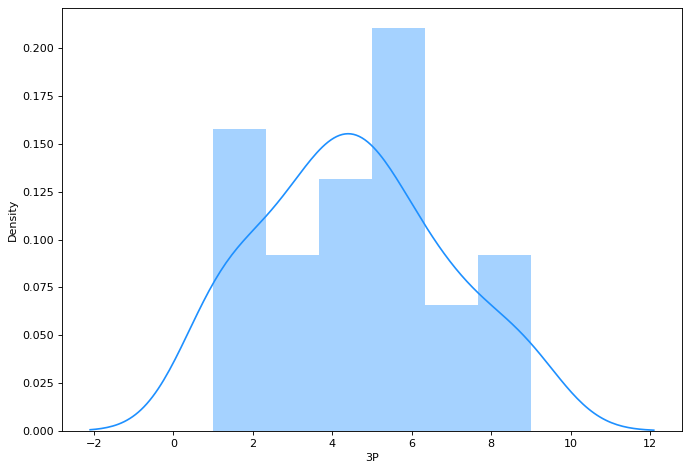

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


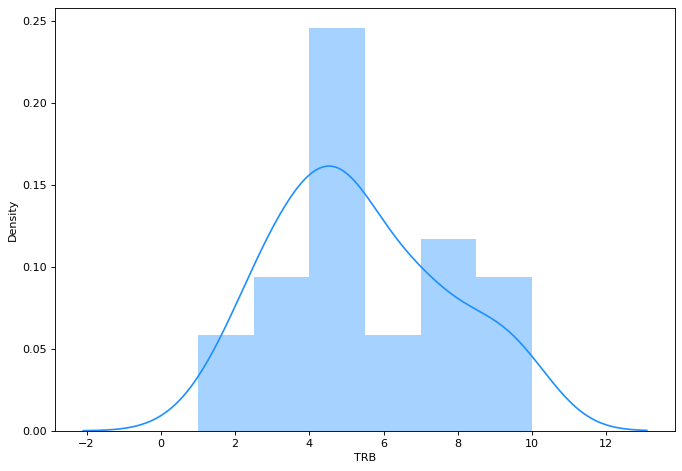

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


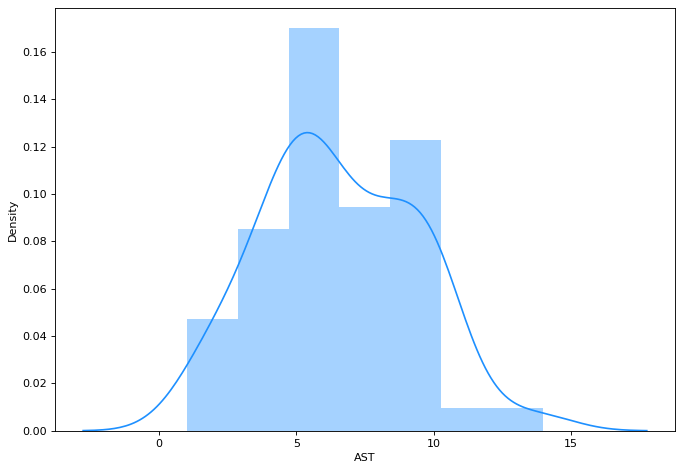

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


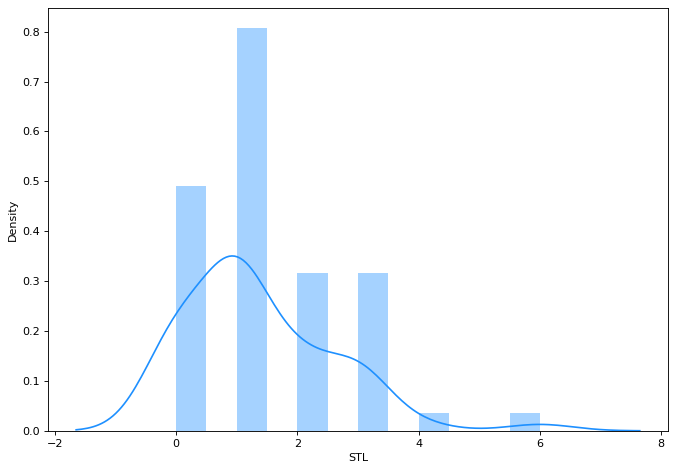

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


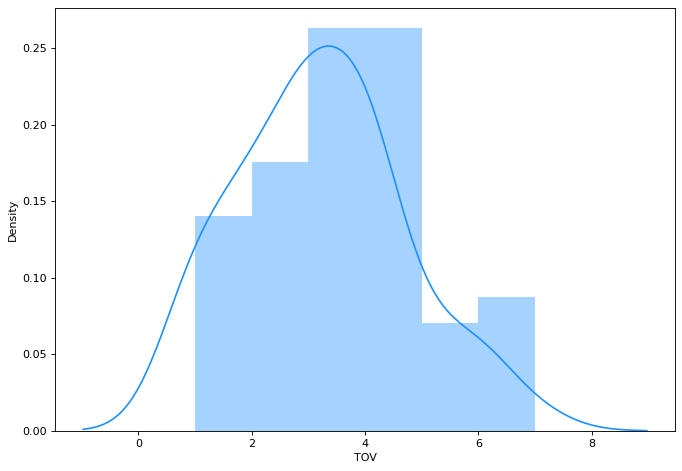

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


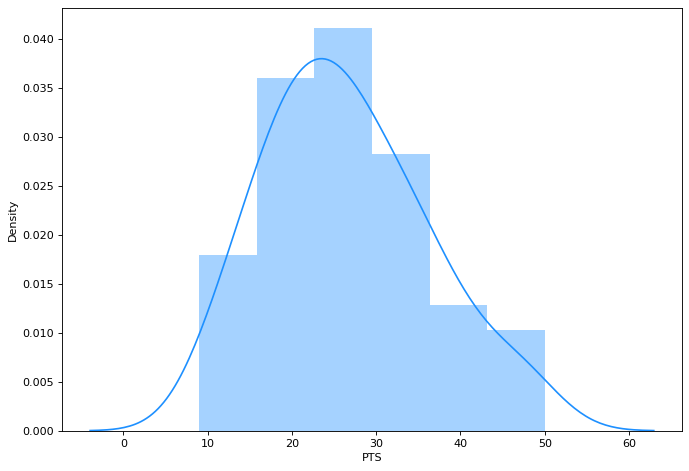

In [31]:
#Realizar as análises de distribuição (média, desvio padrão, histograma) #boxplot
#Verificar a normalidade dos dados

dic_hist = {}

for var in lista_var:
    dados = result_final.loc[(result_final['Season'] == '2021-2022'),var]
    dados = pd.DataFrame(dados, columns=[var])
    dic_hist[var] = dados

    plt.figure(figsize=(10,7), dpi= 80)
    sns.distplot(dic_hist[var][var], color="dodgerblue", label="Compact",)
    ##sns.distplot(dic_hist['3P']['3P'], color="red", label="Compact",) Para analisar a distribuição com filtros (Mandante, contra melhores times, etc)
    plt.show()


In [ ]:
'''
media = df_.loc[(df_['ano_campeonato'] == ano) & (df_[var1] == time),'media'].values
std = df_.loc[(df_['ano_campeonato'] == ano) & (df_[var1] == time),'desvpad'].values
maximo = df_.loc[(df_['ano_campeonato'] == ano) & (df_[var1] == time),'maximo'].values
minimo = df_.loc[(df_['ano_campeonato'] == ano) & (df_[var1] == time),'minimo'].values


x_axis = np.arange(minimo[0]-std[0], maximo[0]+std[0], 0.01)    
plt.plot(x_axis, norm.pdf(x_axis, media[0], std[0])) 
plt.show()'''

print(result_final.columns)


Index(['Rk', 'G', 'Date', 'Age', 'Tm', 'Home/Away', 'Opp', 'Result', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-',
       'Season', 'Overall', 'Home', 'Road', 'DRtg', 'eFG%', 'Aproveitamento'],
      dtype='object')


                  Date   DRtg   Overall      Home      Road   eFG%  3P  TRB  \
Date                                                                          
2021-10-19  2021-10-19  113.3  0.402439  0.512195  0.292683  0.540   2   10   
2021-10-21  2021-10-21  110.1  0.512195  0.609756  0.414634  0.514   8   10   
2021-10-24  2021-10-24  115.3  0.365854  0.390244  0.341463  0.551   4    7   
2021-10-26  2021-10-26  112.8  0.292683  0.292683  0.292683  0.533   4    6   
2021-10-28  2021-10-28  109.0  0.682927  0.731707  0.634146  0.523   7    7   
2021-11-05  2021-11-05  113.0  0.439024  0.463415  0.414634  0.547   5    3   
2021-11-08  2021-11-08  114.9  0.524390  0.658537  0.390244  0.543   9    7   
2021-11-10  2021-11-10  111.7  0.560976  0.634146  0.487805  0.535   3    5   
2021-11-12  2021-11-12  113.6  0.560976  0.658537  0.463415  0.541   9    4   
2021-11-14  2021-11-14  113.7  0.524390  0.536585  0.512195  0.544   3    6   

            AST  STL  TOV  PTS  
Date              

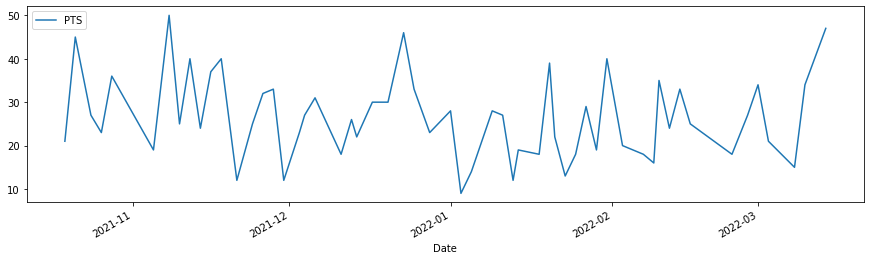

In [33]:
#Analisar séries temporais (jogo a jogo)

lista = ['Date','DRtg','Overall', 'Home', 'Road', 'eFG%', '3P', 'TRB', 'AST', 'STL', 'TOV', 'PTS']
timeseries = result_final.loc[(result_final['Season'] == '2021-2022'),lista]

timeseries.index = pd.to_datetime(timeseries.Date)

timeseries=timeseries.sort_index()

print(timeseries.head(10))

#eliminar a coluna DATE, pois ela já seria o indice
##df.drop("data", inplace=True, axis=1)

##timeseries.plot(figsize=(15,4))
##timeseries.plot(subplots=True, figsize=(15,6))
timeseries.plot(y=['PTS'], figsize=(15,4))
##timeseries.plot(x="R", y=["F10.7", "Dst"], style='.')

#Plotar o gráfico
##plt.plot(timeseries.index, timeseries.chutes_man)

In [34]:
#Utilizar o dia e o mês como atributos de entrada (Avaliar)

def discretize_date(current_date, t):

    cdate = datetime.strptime(current_date, '%Y-%m-%d')

    if t == 'month_sin':
        return float(np.sin(2 * np.pi * cdate.month/12.0))
    if t == 'month_cos':
        return float(np.cos(2 * np.pi * cdate.month/12.0))
    if t == 'day_sin':
        return np.sin(2 * np.pi * cdate.timetuple().tm_yday/365.0)
    if t == 'day_cos':
         return np.cos(2 * np.pi * cdate.timetuple().tm_yday/365.0)
    

date_types = ['day_sin', 'day_cos', 'month_sin', 'month_cos']
for dt in date_types:
    result_final[dt] = result_final['Date'].apply(lambda x : discretize_date(x, dt))


In [35]:
#Selecionar as colunas que vão ser utilizadas no modelo (Testar diversas configurações)

list_columns = ['G','day_sin','day_cos', 'month_sin', 'month_cos', 'Home/Away','Aproveitamento','eFG%','DRtg']


#Substituindo os outliers por um valor máximo e minimo


import copy

mean = result_final['PTS'].mean()
std = result_final['PTS'].std()



def out(valor):
    if valor > (mean + (1.5*std)):
        valor = mean + 1.5*std
    if valor < (mean - (1.5*std)):
        valor = mean - 1.5*std
    return valor


result_final_out = copy.deepcopy(result_final)
result_final_out['PTS'] = result_final['PTS'].apply(lambda x: out(x))

X = result_final_out.loc[:,list_columns].values
y = result_final_out.loc[:,"PTS"].values



In [36]:
#Realizar a normalização das variáveis
#Revisar scaler
##X_producao = [36, 0.5234156073655503, 0.8520775211013093, 0.8660254037844386, 0.5000000000000001, 0, 0.6206,0.539,113.3]

'''from sklearn.preprocessing import StandardScaler

standardScaler=StandardScaler()


scaler = standardScaler.fit(X)
X = scaler.transform(X)'''

from sklearn.preprocessing import PowerTransformer


X = PowerTransformer(method="yeo-johnson").fit_transform(X)

print(X.shape)

(403, 9)


In [37]:
#Realizar a separação entre teste e treino

from sklearn.model_selection import train_test_split
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)

In [38]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(150, 100, 50),
                       max_iter = 100,activation = 'relu',
                       solver = 'adam',
                       alpha = 0.001,
                       learning_rate = 'constant'
                       )

mlp_reg.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.001, hidden_layer_sizes=(150, 100, 50), max_iter=100)

In [39]:
y_pred = mlp_reg.predict(X_test)
##y_producao = mlp_reg.predict(X_producao)
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(20)
##print(y_producao)

,Actual,Predicted
0,28.000000,27.468012
1,34.000000,29.556002
2,27.000000,28.348698
3,33.000000,28.500881
4,27.000000,22.556479
5,27.000000,32.370186
6,26.000000,29.620989
7,33.000000,33.135563
8,17.000000,29.158577
9,14.947976,30.674837


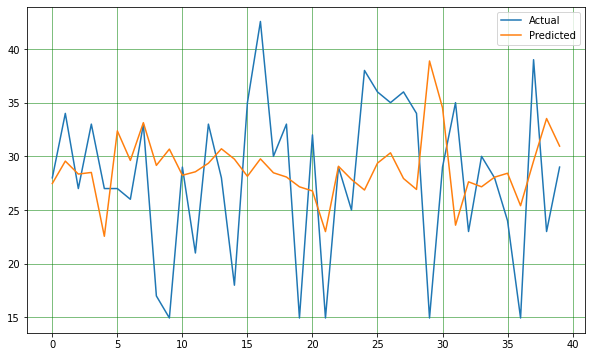

Mean Absolute Error: 6.9290504
Mean Squared Error: 74.24178
Root Mean Squared Error: 8.616367
Demonstração: 



'for i in range(20):\n    print(f"Valor previsto para o jogo: {y_pred[i]} -> Valor real: {y_test[i]}")'

In [40]:
df_temp = df_temp.head(40)
df_temp.plot(kind='line',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("Demonstração: \n")
'''for i in range(20):
    print(f"Valor previsto para o jogo: {y_pred[i]} -> Valor real: {y_test[i]}")'''

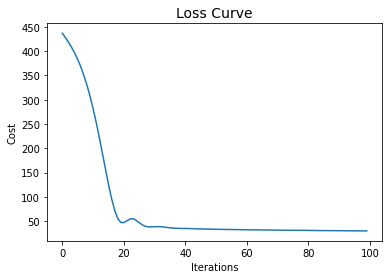

In [41]:
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30), (50,25,15)],
    'max_iter': [20, 50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(mlp_reg, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_) 

KeyboardInterrupt: ignored

In [42]:
saidas = ['3P', 'TRB', 'AST', 'STL', 'TOV', 'PTS']

means = {}

for var in saidas:

    mean = result_final_out[var].mean()
    means[var] = mean

    condicoes = [(result_final_out[var] > mean), 
             (result_final_out[var] <= mean)]
    opcoes = [1,0]
    result_final_out[str(var)+"_logic"] = np.select(condicoes, opcoes)

##teste = result_final[['Date','Home/Away','Opp','Result','MP','PTS','PTS_logic']]
print(result_final_out.head(10))

    Rk     G        Date     Age   Tm  Home/Away  Opp  Result GS     MP  ...  \
0    1   1.0  2015-10-27  27-227  GSW          1  NOP      16  1  35:37  ...   
1    3   3.0  2015-10-31  27-231  GSW          0  NOP      14  1  35:38  ...   
2   66  63.0  2016-03-14  28-000  GSW          1  NOP      18  1  31:18  ...   
3    2   2.0  2015-10-30  27-230  GSW          0  HOU      20  1  27:24  ...   
5   51  49.0  2016-02-09  27-332  GSW          1  HOU      13  1  37:41  ...   
6    4   4.0  2015-11-02  27-233  GSW          1  MEM      50  1  28:24  ...   
7    9   9.0  2015-11-11  27-242  GSW          0  MEM      16  1  34:30  ...   
9   82  79.0  2016-04-13  28-030  GSW          1  MEM      21  1  29:46  ...   
10   5   5.0  2015-11-04  27-235  GSW          1  LAC       4  1  32:38  ...   
11  13  13.0  2015-11-19  27-250  GSW          0  LAC       7  1  36:46  ...   

     day_sin   day_cos month_sin     month_cos 3P_logic TRB_logic AST_logic  \
0  -0.899631  0.436651 -0.866025  5.0000

In [43]:
#Selecionar as colunas que vão ser utilizadas no modelo (Testar diversas configurações)

list_columns = ['G','day_sin','day_cos', 'month_sin', 'month_cos', 'Home/Away','Aproveitamento','eFG%']

X = result_final_out.loc[:,list_columns].values
y = result_final_out.loc[:,"PTS_logic"].values

In [44]:
#Realizar a normalização das variáveis

#Modelo Standart de normalização
'''from sklearn.preprocessing import StandardScaler

sc=StandardScaler()

scaler = sc.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape'''

#Modelo de normalização que lida melhor com outliers

from sklearn.preprocessing import PowerTransformer


X = PowerTransformer(method="yeo-johnson").fit_transform(X)

print(X.shape)

(403, 8)


In [45]:
#Realizar a separação entre teste e treino

from sklearn.model_selection import train_test_split
X = np.asarray(X).astype(np.float64)
y = np.asarray(y).astype(np.float64)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)

print(y_test)


[0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


(270, 8)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.

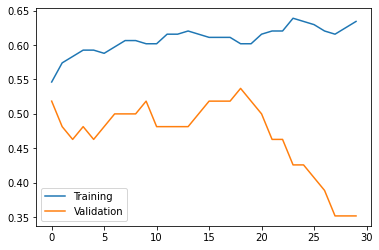

In [60]:
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        
        tf.keras.Input(shape=(len(X_train[0]),)),
        Dense(30, activation='relu',name = 'L_1'),
        Dense(15, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.12),name = 'L_2'),
        Dense(5, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.2),name = 'L_3'),
        Dense(1, activation='sigmoid',name = 'L_4')
         
    ], name = "my_model" 
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics = ['acc']
)

simple_logging = LambdaCallback(on_epoch_end = lambda e, l: print(e, end='.'))

E = 30

h = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = E,
    callbacks = [simple_logging],
    verbose = False
            )

plt.plot(range(E),h.history['acc'], label = 'Training')
plt.plot(range(E),h.history['val_acc'], label = 'Validation')
plt.legend()
plt.show()

In [62]:
#Melhor resultado obtido até agora: 60.80 AUC
#Verificar se a eliminação dos outliers e dos jogos com pouca minutagem vai influenciar

#use a threshold to classifier in 0 or 1 for use the confusion matrix
predictions = model.predict(X_test)
erros = []
threshold = []
for i in range(0,len(predictions)):
    if predictions[i]>0.5:
        threshold.append(1)
    else:
        threshold.append(0)
    if threshold[i] != y_test[i]:
        erros.append(i)
        
#confusion matrix
matrix = metrics.confusion_matrix(y_test, threshold)
print(matrix)

##print(predictions)
#auc
auc = metrics.roc_auc_score(y_test, predictions)
print(auc)

##print(predictions)

fscore = metrics.f1_score(y_test,threshold)
print(fscore)

print(max(predictions))

5/5 [==============================] - 0s 5ms/step
[[37 36]
 [22 38]]
0.6381278538812786
0.5671641791044775
[0.56984085]


[16:24:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


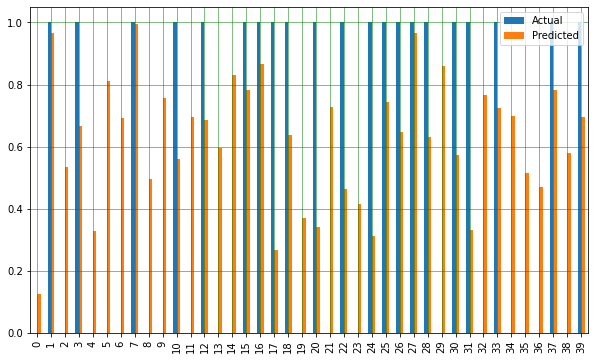

0.5972602739726027
[[36 37]
 [21 39]]
0.573529411764706
Previsao: 0.12540003657341003 => Real: 0.0
Previsao: 0.966738224029541 => Real: 1.0
Previsao: 0.534419059753418 => Real: 0.0
Previsao: 0.6668625473976135 => Real: 1.0
Previsao: 0.3274587392807007 => Real: 0.0
Previsao: 0.8123903870582581 => Real: 0.0
Previsao: 0.6913485527038574 => Real: 0.0
Previsao: 0.9958330392837524 => Real: 1.0
Previsao: 0.496329128742218 => Real: 0.0
Previsao: 0.7552331686019897 => Real: 0.0
Previsao: 0.5587707757949829 => Real: 1.0
Previsao: 0.6939309239387512 => Real: 0.0
Previsao: 0.6859586238861084 => Real: 1.0
Previsao: 0.5953183174133301 => Real: 0.0
Previsao: 0.8300374746322632 => Real: 0.0
Previsao: 0.7815103530883789 => Real: 1.0
Previsao: 0.8666516542434692 => Real: 1.0
Previsao: 0.26725900173187256 => Real: 1.0
Previsao: 0.63649982213974 => Real: 1.0
Previsao: 0.3708348870277405 => Real: 0.0


In [58]:
#Desenolver xgboost para melhorar o desempenho (auc e f-score)

'''from xgboost import XGBRegressor

# instanciar o modelo XGBoost
model = XGBRegressor()
# chamar o fit para o modelo
model.fit(X_train, y_train, verbose=False)
# fazer previsões em cima do dataset de teste
predictions = model.predict(X_test)

df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df_temp.head()

df_temp = df_temp.head(40)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

threshold = []
for i in range(0,len(predictions)):
    if predictions[i]>0.5:
        threshold.append(1)
    else:
        threshold.append(0)
    if threshold[i] != y_test[i]:
        erros.append(i)

auc = metrics.roc_auc_score(y_test, predictions)
print(auc)

##print(predictions)
matrix = metrics.confusion_matrix(y_test, threshold)
print(matrix)

fscore = metrics.f1_score(y_test,threshold)
print(fscore)

for i in range(20):
    print(f"Previsao: {predictions[i]} => Real: {y_test[i]}")'''